In [1]:
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime
import pickle

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
%load_ext autotime

time: 677 µs (started: 2021-09-07 12:49:08 +00:00)


### 0. Loading training data

In [2]:
# df = pd.read_parquet('../data/processed/train_features.parquet')
# df = pd.read_parquet('../data/processed/train_features_uncorr.parquet')
df = pd.read_parquet('../data/processed/train_features_undersample.parquet')
df.shape

(213451, 1106)

time: 3.22 s (started: 2021-09-07 12:49:22 +00:00)


In [3]:
if 'train_flag' in list(df):
    df.drop('train_flag', inplace=True, axis=1)
    df.shape

time: 3.02 s (started: 2021-09-07 12:49:27 +00:00)


In [4]:
y, x = df.pop('country_destination'), df
x.drop('user_id', axis=1, inplace=True)

time: 25 s (started: 2021-09-07 12:49:30 +00:00)


### 1. Splitting tain data into stratified train, validation and test sets

In [5]:
cat_features = [
    'gender',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
    'dow_registered',
    'hr_registered',
    'age_group',
    'dow_registered',
    'day_registered',
    'month_registered',
    'year_registered',
]

time: 33.7 ms (started: 2021-09-07 12:49:55 +00:00)


In [6]:
cat_features_remained = list(set(cat_features).intersection(set(df)))
cat_features_removed = set(cat_features) - set(df)
len(cat_features), len(cat_features_remained), len(cat_features_removed)                                      

(17, 16, 0)

time: 66.6 ms (started: 2021-09-07 12:49:55 +00:00)


In [7]:
for col in cat_features_remained:
    try:
        if col not in list(x):
            print(col)
            continue
        if str(x[col].dtype) != 'category':
            x[col].fillna('', inplace=True)
            x[col] = x[col].astype('category')
            
    except Exception as e:
        print(col)
        print(e)

time: 1.1 s (started: 2021-09-07 12:49:55 +00:00)


In [8]:
x_train_large, x_test, y_train_large, y_test = train_test_split(
    x, 
    y, 
    train_size=0.9, 
    random_state=42,
    stratify=y
)
x_train_large.shape, x_test.shape

((192105, 1103), (21346, 1103))

time: 4.24 s (started: 2021-09-07 12:49:56 +00:00)


In [9]:
x_train, x_validation, y_train, y_validation = train_test_split(
    x_train_large, 
    y_train_large, 
    train_size=0.8,
    random_state=42,
    stratify=y_train_large
)
x_train.shape, x_validation.shape

((153684, 1103), (38421, 1103))

time: 3.23 s (started: 2021-09-07 12:50:01 +00:00)


### 1.1 Checking that the ratios of the target class are invariant

In [10]:
# y_train.value_counts() / len(y_train)

time: 1.21 ms (started: 2021-09-07 09:23:30 +00:00)


In [11]:
# y_validation.value_counts() / len(y_validation)

time: 37.6 ms (started: 2021-09-07 09:23:30 +00:00)


### 2. Model Training

In [10]:
classes = np.unique(y_train)
classes

array(['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US',
       'other'], dtype=object)

time: 201 ms (started: 2021-09-07 12:50:06 +00:00)


In [11]:
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
weights

array([33.00773196, 12.45817121, 16.76308901,  7.91043854,  3.54077965,
        7.65053763,  6.27486526,  0.14282369, 23.32786885, 82.09615385,
        0.28517034,  1.76210787])

time: 119 ms (started: 2021-09-07 12:50:06 +00:00)


In [12]:
class_weights = dict(zip(classes, weights))

time: 882 µs (started: 2021-09-07 12:50:07 +00:00)


In [13]:
model = CatBoostClassifier(
    iterations=100,
    random_seed=42,
#     learning_rate=0.25,
    custom_loss=['AUC', 'Accuracy'],
    loss_function='MultiClass',
#     class_weights=class_weights,
#     depth=7,
#     eval_metric
)

time: 30.7 ms (started: 2021-09-07 12:50:08 +00:00)


In [35]:
model.fit(
    x_train, y_train,
    cat_features=cat_features_remained,
    eval_set=(x_validation, y_validation),
    early_stopping_rounds=50,
    use_best_model=True,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

time: 7min 59s (started: 2021-09-07 08:24:01 +00:00)


### 3. Testing model on test sets

In [19]:
y_pred = model.predict(x_test)

time: 297 ms (started: 2021-09-06 13:57:13 +00:00)


In [20]:
labels = y_validation.value_counts().index.tolist()
labels

['NDF', 'US', 'other', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE', 'NL', 'AU', 'PT']

time: 13.4 ms (started: 2021-09-06 13:57:14 +00:00)


In [21]:
cm = confusion_matrix(y_test, y_pred, labels=labels, normalize='all')

time: 91.2 ms (started: 2021-09-06 13:57:15 +00:00)


### Confusion Matrix when iterations=500

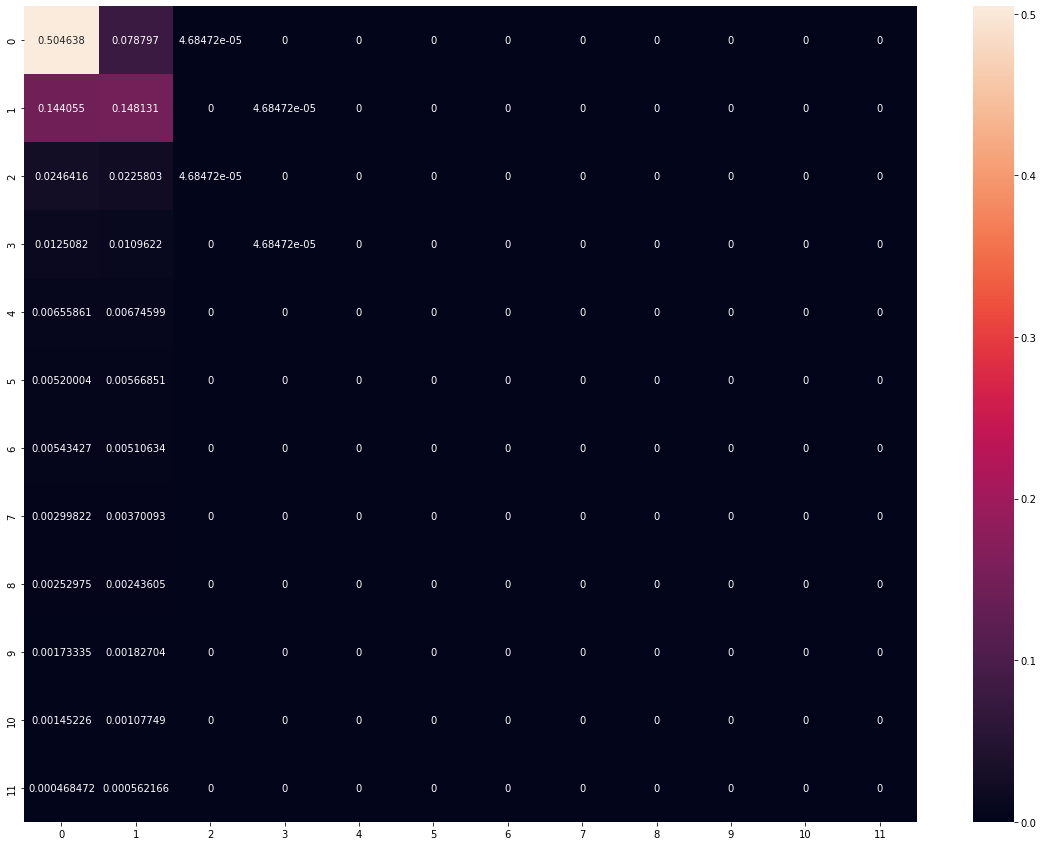

time: 1.23 s (started: 2021-09-06 13:57:23 +00:00)


In [22]:
plt.figure(figsize = (20, 15))
sns.heatmap(cm, annot=True, fmt='g');

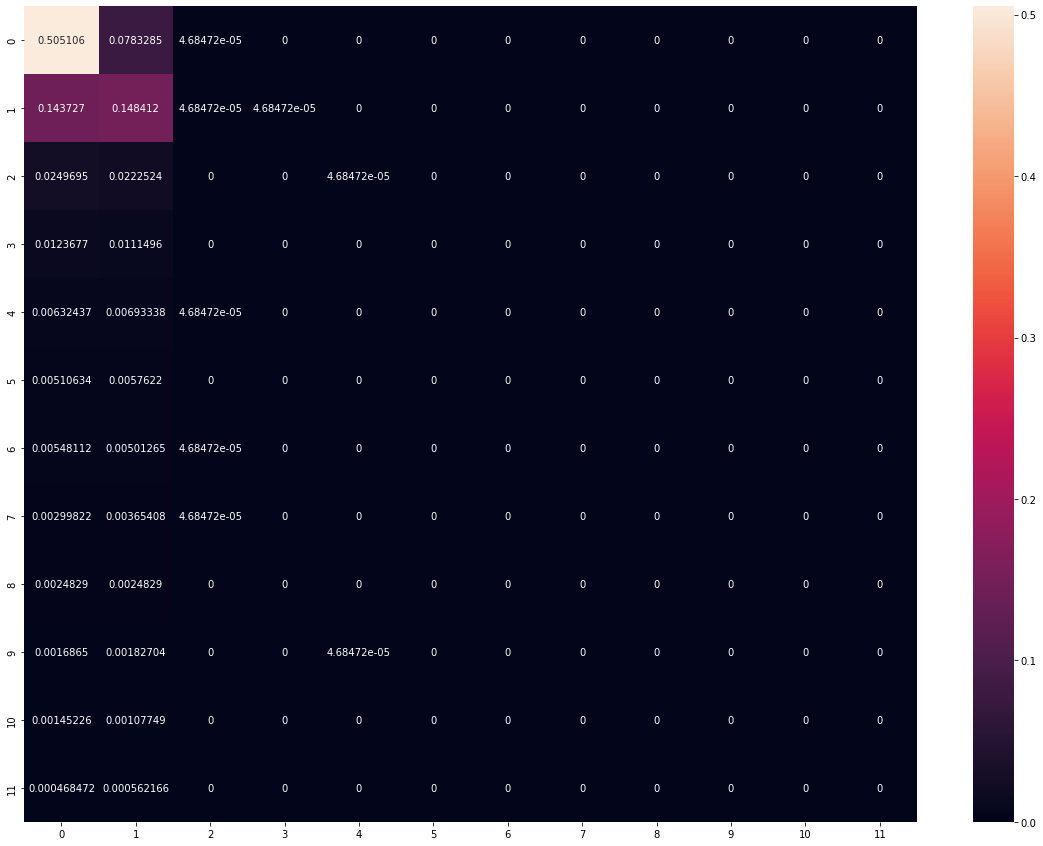

time: 1.13 s (started: 2021-08-17 18:13:12 +00:00)


In [25]:
plt.figure(figsize = (20, 15))
sns.heatmap(cm, annot=True, fmt='g');

### Confusion Matrix when using class weights

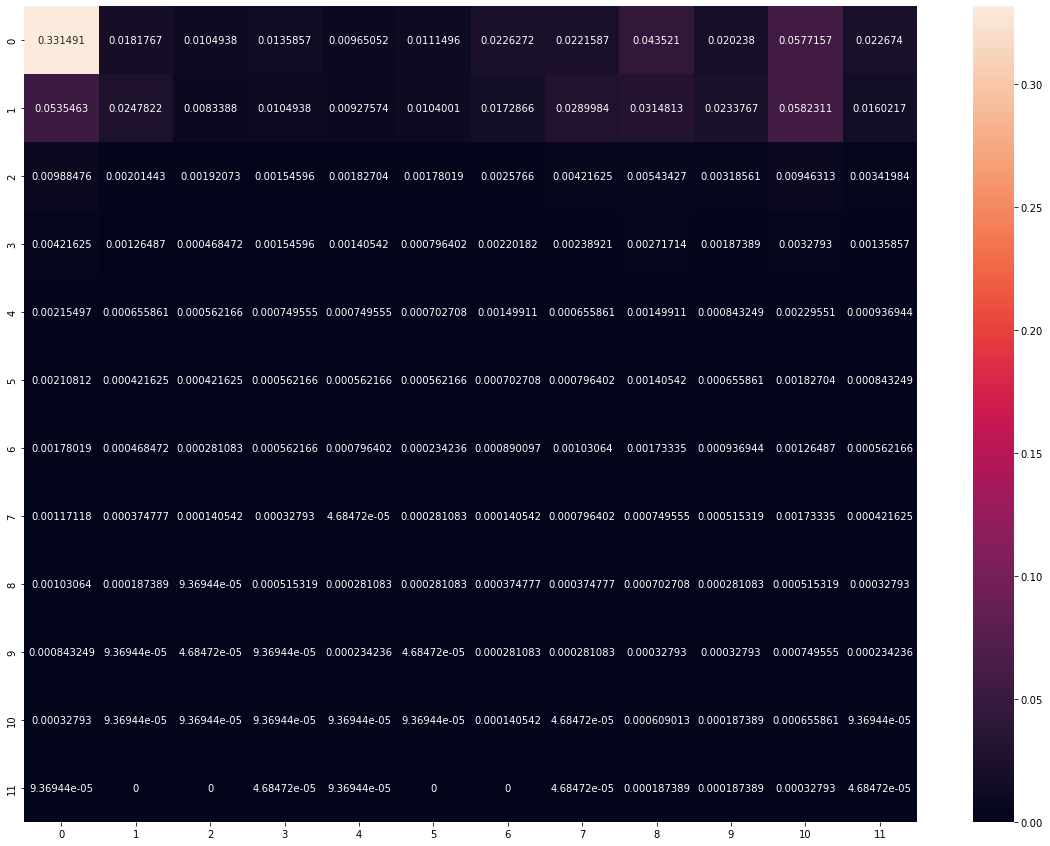

time: 1.58 s (started: 2021-08-17 15:10:05 +00:00)


In [19]:
plt.figure(figsize = (20, 15))
sns.heatmap(cm, annot=True, fmt='g');

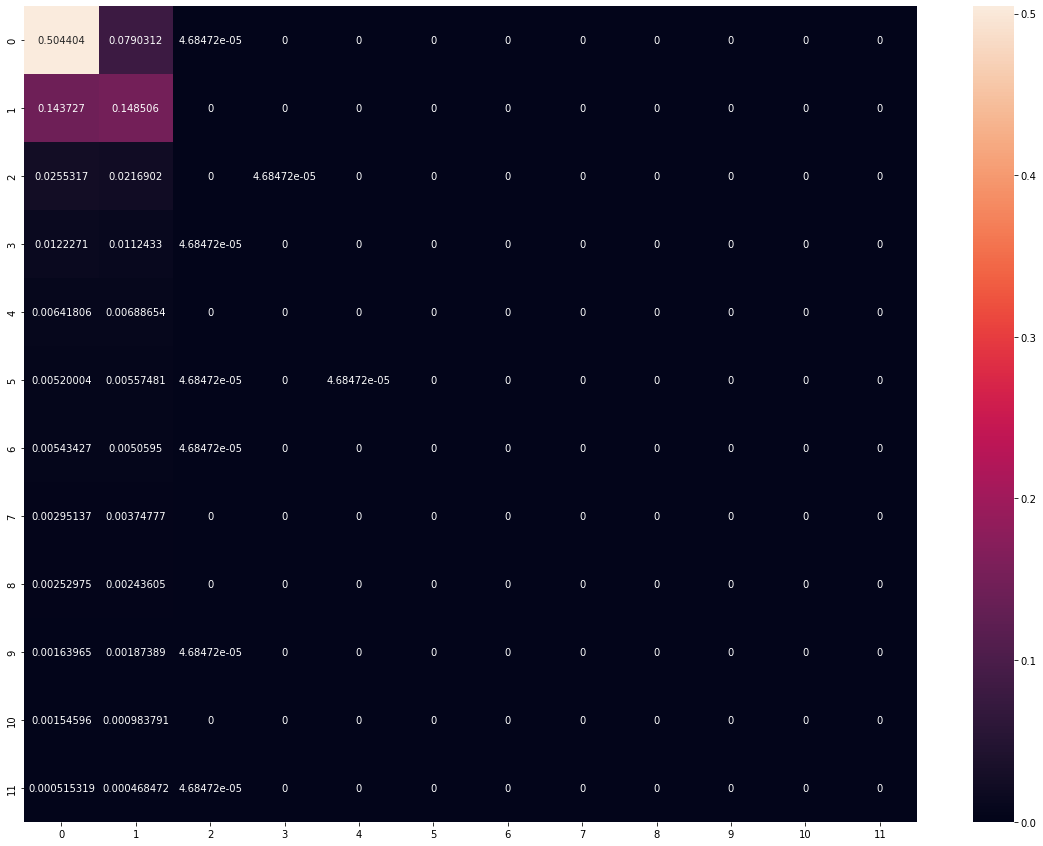

time: 1.55 s (started: 2021-08-17 12:02:14 +00:00)


In [18]:
plt.figure(figsize = (20, 15))
sns.heatmap(cm, annot=True, fmt='g');

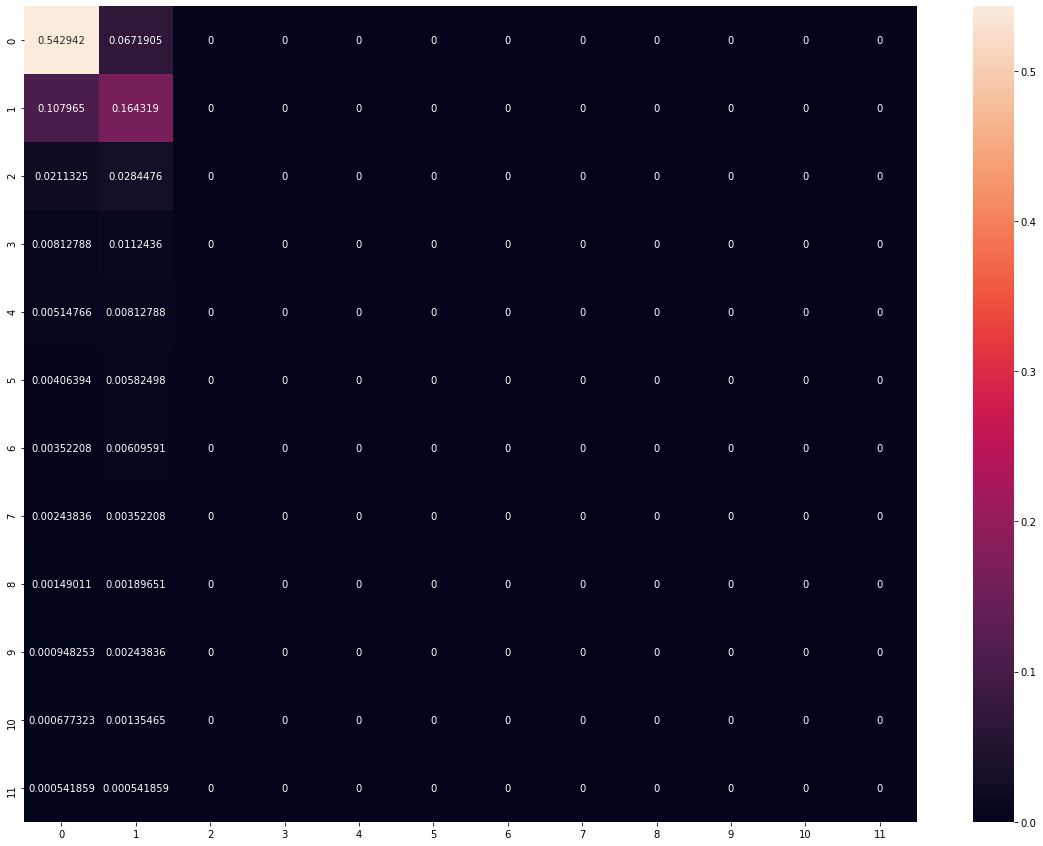

time: 896 ms (started: 2021-08-16 12:42:38 +00:00)


In [19]:
plt.figure(figsize = (20, 15))
sns.heatmap(cm, annot=True, fmt='g');

### 4. Training on x_train_large, i.e. on 90% of training data instead of 70%

In [14]:
model.fit(
    x_train_large, y_train_large,
    cat_features=cat_features_remained,
    eval_set=(x_test, y_test),
    early_stopping_rounds=10,
    use_best_model=True,
    verbose=False,
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

time: 22min 18s (started: 2021-09-07 12:50:15 +00:00)


In [15]:
y_pred = model.predict(x_test)

time: 577 ms (started: 2021-09-07 13:13:04 +00:00)


In [16]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.6541740841375433

time: 114 ms (started: 2021-09-07 13:13:07 +00:00)


In [20]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.653002904525438

time: 58.6 ms (started: 2021-09-07 09:46:16 +00:00)


In [25]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.6530965988944064

time: 100 ms (started: 2021-09-06 14:22:05 +00:00)


In [26]:
accuracy_score(y_true=y_test, y_pred=y_pred)

0.6530965988944064

time: 75.5 ms (started: 2021-09-06 14:22:06 +00:00)


In [ ]:
[a1, a2, a2, a3, a1, a2]

### 5. Saving Model

In [17]:
def save_model(model, ext='cbm'):
    ts = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    if ext == 'cbm':
        print(f'saving model with ts: {ts}')
        model.save_model(f'../models/model_{ts}.cbm')

time: 6.54 ms (started: 2021-09-07 13:13:21 +00:00)


In [18]:
save_model(model)

saving model with ts: 2021_09_07_13_13_22
time: 28.7 ms (started: 2021-09-07 13:13:22 +00:00)


1. Features set reduction by
 - columns with nan values over 99%
 - low variance removel
 - highly correlated features > 0.80 (both with absolute)
2. Change submission generating, take top X with sum of probabilities > 90%

In [19]:
with open('../data/processed/x_test_uncorr.pickle', 'wb') as f:
    pickle.dump(x_test, f)

time: 2.3 s (started: 2021-09-07 13:13:27 +00:00)


In [20]:
with open('../data/processed/y_test_uncorr.pickle', 'wb') as f:
    pickle.dump(y_test, f)

time: 20.8 ms (started: 2021-09-07 13:13:30 +00:00)
